In [1]:
import os
from scipy.linalg import svd 
from IPython.core.display import SVG
import pyomo.environ as pyo
import idaes
import pytest
import idaes.logger as idaeslog
from idaes.core.util.model_statistics import degrees_of_freedom as dof
import idaes.core.util.exceptions as idaes_except
from idaes.core.solvers import use_idaes_solver_configuration_defaults
import idaes.core.util.scaling as iscale
import soec_standalone_flowsheet
from soec_flowsheet_costing import (
    get_solo_soec_capital_costing,
    initialize_flowsheet_costing,
    scale_flowsheet_costing,
    get_soec_OM_costing,
    display_soec_costing
)
import idaes.core.util.model_statistics as mstat
from idaes.models.properties import iapws95
from pyomo.util.check_units import assert_units_consistent
import idaes.core.util as iutil

import numpy as np
import pandas as pd

In [2]:
from pyomo.core.expr.current import identify_variables
from pyomo.common.collections import ComponentSet
def find_active_constraints_containing_variable(var, blk):
    con_set = ComponentSet()
    CUID = pyo.ComponentUID(var)
    for c in blk.component_data_objects(ctype=pyo.Constraint, active=True, descend_into=True):
        for v in identify_variables(c.body):
            if CUID.matches(v):
                con_set.add(c)
    return con_set

In [3]:
use_idaes_solver_configuration_defaults()
idaes.cfg.ipopt.options.nlp_scaling_method = "user-scaling"
idaes.cfg.ipopt.options.OF_ma57_automatic_scaling = "yes"
idaes.cfg.ipopt["options"]["linear_solver"] = "ma57"
idaes.cfg.ipopt["options"]["max_iter"] = 300
idaes.cfg.ipopt["options"]["halt_on_ampl_error"] = "no"

In [4]:
m = pyo.ConcreteModel()
m.fs = soec_standalone_flowsheet.SoecStandaloneFlowsheet(dynamic=False)
iscale.calculate_scaling_factors(m)

2022-12-09 15:49:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 15:49:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 15:49:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 15:49:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 15:49:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 15:49:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 15:49:09 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flas

In [5]:
m.fs.initialize_build(outlvl=idaeslog.INFO_LOW)#, load_from="soec_standalone_init.json.gz")
# m.fs.initialize_build(outlvl=idaeslog.DEBUG)

WARNING (W1002): Setting Var 'fs.water_evaporator01.hot_side.properties_in[0.0
    ].log_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_evaporator01.hot_side.properties_out[0.
    0].log_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_preheater.hot_side.properties_in[0.0].l
    og_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value `4.403681862637669e-10`
    outside the bounds (None, 0).
    See also https://pyomo.readthedocs.io/en/latest/errors.html#w1002
WARNING (W1002): Setting Var 'fs.water_preheater.hot_side.properties_out[0.0].
    log_mole_frac_tdew[Vap,Liq,H2O]' to a numeric value
    `4.403681862637669e-10` outside the bounds (None, 0).
    See also h

In [6]:
print(dof(m))
get_solo_soec_capital_costing(m.fs, CE_index_year="2018")
get_soec_OM_costing(m.fs)
print(dof(m))
iscale.calculate_scaling_factors(m)

0
0
2022-12-09 15:50:41 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 15:50:41 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash01.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 15:50:41 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 15:50:41 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash03.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 15:50:41 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_in[0.0].mole_frac_comp
2022-12-09 15:50:41 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_flash04.control_volume.properties_out[0.0].mole_frac_comp
2022-12-09 15:50:41 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.product_

In [7]:
solver = pyo.SolverFactory("ipopt")

In [8]:
initialize_flowsheet_costing(m.fs)
scale_flowsheet_costing(m.fs)

m.fs.tags_output["annual_water_cost"] = iutil.ModelTag(
    doc="Annual water cost",
    expr=m.fs.costing.annual_water_cost,
    format_string="{:.2f}",
)

In [9]:
assert dof(m) == 0
solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 300, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=300
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpd9pwtwj7_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpd9pwtwj7_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2454, 'Number of variables': 2454, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 1.1381909847259521}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [10]:
def set_indexed_variable_bounds(var,bounds):
    for idx, subvar in var.items():
        subvar.bounds = bounds
if True:
    m.fs.obj = pyo.Objective(
        expr = (
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.total_annualized_cost
            + m.fs.costing.annual_fixed_operations_and_maintenance_cost
            + m.fs.costing.annual_air_cost
        )
    )
    
    m.fs.max_raw_water_withdrawal_eqn.deactivate()
    m.fs.feed_heater.max_heat_duty_eqn.deactivate()
    m.fs.sweep_heater.max_heat_duty_eqn.deactivate()
    m.fs.heat_pump.max_heat_duty_eqn.deactivate()
    
    m.fs.max_raw_water_withdrawal_ineq.activate()
    m.fs.feed_heater.max_heat_duty_ineq.activate()
    m.fs.sweep_heater.max_heat_duty_ineq.activate()
    m.fs.heat_pump.max_heat_duty_ineq.activate()
    
    for hx in [m.fs.feed_hot_exchanger, m.fs.sweep_hot_exchanger, m.fs.sweep_medium_exchanger,
              m.fs.water_evaporator01, m.fs.water_evaporator02, m.fs.water_evaporator03,
              m.fs.water_evaporator04, m.fs.water_evaporator05, m.fs.water_preheater]:
        set_indexed_variable_bounds(hx.delta_temperature_in, (0, None))
        set_indexed_variable_bounds(hx.delta_temperature_out, (0, None))
        hx.area.bounds = (400, None)
        hx.area.unfix()
    
    # I suspect there are several solutions close in price with areas portioned
    # differerently between evaporators. Fix these areas to (hopefully) force
    # IPOPT to just choose one
    m.fs.water_evaporator01.area.fix(2018)
    m.fs.water_evaporator04.area.fix(5245)
    
    @m.fs.Constraint(m.fs.time)
    def water_evaporator02_vapor_out_ineq(b,t):
        try:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Vap","Liq"]
        except KeyError:
            tdew = b.water_evaporator02.shell.properties_out[t].temperature_dew["Liq","Vap"]
        return (
            b.water_evaporator02.shell.properties_out[t].temperature 
            >= tdew
        )
#     @m.fs.Constraint(m.fs.time)
#     def water_evaporator03_vapor_out_ineq(b,t):
#         try:
#             tdew = b.water_evaporator03.shell.properties_out[t].temperature_dew["Vap","Liq"]
#         except KeyError:
#             tdew = b.water_evaporator03.shell.properties_out[t].temperature_dew["Liq","Vap"]
#         return (
#             b.water_evaporator03.shell.properties_out[t].temperature 
#             >= tdew
#         )
    iscale.constraint_scaling_transform(m.fs.water_evaporator02_vapor_out_ineq[0], 1e-2)
#     iscale.constraint_scaling_transform(m.fs.water_evaporator03_vapor_out_ineq[0], 1e-2)
    
    
    for cmp in [m.fs.sweep_blower, m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        set_indexed_variable_bounds(cmp.work_mechanical, (0, None))
    set_indexed_variable_bounds(m.fs.water_compressor.control_volume.work, (0, None))
    
    m.fs.h2_mass_production.fix(2)
    m.fs.water_preheater.tube_inlet.flow_mol.unfix()
    m.fs.soec_single_pass_water_conversion.unfix()
    m.fs.feed_recycle_split.split_fraction.unfix()
    m.fs.sweep_recycle_split.split_fraction.unfix()
    m.fs.sweep_blower.inlet.flow_mol.unfix()
    #m.fs.sweep_blower.control_volume.properties_out[:].pressure.unfix()
    m.fs.feed_heater.outlet.temperature.unfix()
    m.fs.sweep_heater.outlet.temperature.unfix()
    
    
    
    m.fs.soec_module.potential_cell.unfix()
    m.fs.soec_module.number_cells.unfix()
    m.fs.costing.electricity_price.fix(71.7)
    
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.potential, (1.1,1.6))
    set_indexed_variable_bounds(m.fs.water_split.split_fraction, (0.03,0.98))
    set_indexed_variable_bounds(m.fs.feed_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.sweep_heater.heat_duty,(0,None))
    set_indexed_variable_bounds(m.fs.heat_pump_hot_terminus.heat_duty, (0, None))
    set_indexed_variable_bounds(m.fs.sweep_blower.inlet.flow_mol,(1000,None))
    m.fs.feed_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    m.fs.sweep_recycle_split.split_fraction[0,"recycle"].bounds = (0.03,0.5)
    set_indexed_variable_bounds(m.fs.soec_overall_water_conversion, (0.4,0.8))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.temperature_z, (550+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.oxygen_channel.temperature_inlet, (600+273.15,750+273.15))
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.current_density, (-10400,5200))
    set_indexed_variable_bounds(m.fs.heat_source.inlet.flow_mol[0], (1, None))
    
    m.fs.feed_heater.max_heat_duty.set_value(8e6)
    m.fs.sweep_heater.max_heat_duty.set_value(8e6)
    m.fs.feed_heater.max_heat_duty.bounds = (8e6, None)
    m.fs.sweep_heater.max_heat_duty.bounds = (8e6, None)
    #m.fs.heat_pump.max_heat_duty.fix(2e7)
    m.fs.max_raw_water_withdrawal.fix(3000)
    
    for cmp in [m.fs.cmp01, m.fs.cmp02, m.fs.cmp03, m.fs.cmp04]:
        cmp.ratioP.unfix()
        set_indexed_variable_bounds(cmp.ratioP, (1, 3))
        set_indexed_variable_bounds(cmp.outlet.temperature, (273.15, 250+273.15))
    
    m.fs._make_temperature_gradient_terms()
    set_indexed_variable_bounds(m.fs.soec_module.solid_oxide_cell.fuel_electrode.dtemperature_dz, (-750, 750))
    m.fs.make_performance_constraints()
#     @m.fs.Constraint(m.fs.time)
#     def equal_pressures_eqn(b,t):
#        return b.soec_module.fuel_inlet.pressure[t] == b.soec_module.oxygen_inlet.pressure[t]
    
#     iscale.constraint_scaling_transform(m.fs.equal_pressures_eqn[0],1e-5)

    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1643)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from
    C:\Users\cptda\Work\examples-pse\src\Examples\Flowsheets\power_generation\
    standalone_soec\soec_standalone_flowsheet.py:1646)


In [11]:
m.fs.h2_mass_production.fix(5)
jac_unscaled, jac_scaled, nlp = iscale.constraint_autoscale_large_jac(m)
solver.solve(m, tee=True, options={"tol": 3e-8, "max_iter": 500, "halt_on_ampl_error":"no"})

Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=3e-08
linear_solver=ma57
max_iter=500
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp6jxgk0gf_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp6jxgk0gf_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All tec

  67  5.3225009e+02 2.70e-02 1.23e+10  -3.8 3.04e+01    -  7.96e-02 6.10e-05h 15
  68  5.3258141e+02 8.66e-01 8.16e+08  -3.8 3.05e+01    -  6.33e-02 1.00e+00w  1
  69  5.3294035e+02 1.11e+00 1.51e+10  -3.8 5.72e+01    -  5.37e-01 3.74e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  5.3291005e+02 1.00e+00 1.56e+10  -3.8 1.68e+01    -  8.01e-04 9.67e-02w  1
  71  5.3177311e+02 6.06e+00 1.42e+10  -3.8 7.49e+02    -  1.27e-02 8.12e-02h  1
  72r 5.3177311e+02 6.06e+00 1.00e+03   0.8 0.00e+00   9.7 0.00e+00 5.27e-08R  2
  73r 5.3137066e+02 4.36e+00 1.36e+03   0.8 6.96e+03    -  5.44e-04 2.83e-04f  1
  74  5.3137852e+02 4.31e+00 3.68e+02  -3.8 6.22e+00    -  1.18e-02 1.25e-02h  1
  75  5.3142080e+02 4.08e+00 3.49e+02  -3.8 4.89e+00    -  8.71e-02 5.32e-02h  1
  76  5.3153073e+02 3.50e+00 2.99e+02  -3.8 5.16e+00    -  1.00e-01 1.43e-01h  1
  77  5.3180903e+02 2.06e+00 1.74e+02  -3.8 4.59e+00    -  5.87e-01 4.16e-01h  1
  78  5.3213821e+02 3.11e-01

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 2490, 'Number of variables': 2490, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 15.855581283569336}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
m.fs.soec_module.number_cells.pprint()
m.fs.soec_module.solid_oxide_cell.current_density.pprint()
print(pyo.value(m.fs.soec_module.solid_oxide_cell.average_current_density[0]))
print(pyo.value((m.fs.obj)*1e6/(5*m.fs.costing.plant_uptime)))

number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2961547659 :  None : False : False :  Reals
current_density : Size=10, Index=fs.soec_module.solid_oxide_cell.current_density_index, Units=A/m**2
    Key       : Lower  : Value               : Upper : Fixed : Stale : Domain
     (0.0, 1) : -10400 :  -8552.481100048593 :  5200 : False : False :  Reals
     (0.0, 2) : -10400 :  -9872.858860585447 :  5200 : False : False :  Reals
     (0.0, 3) : -10400 :            -10400.0 :  5200 : False : False :  Reals
     (0.0, 4) : -10400 : -10146.127664455767 :  5200 : False : False :  Reals
     (0.0, 5) : -10400 :   -9367.40314420521 :  5200 : False : False :  Reals
     (0.0, 6) : -10400 :  -8331.578728420322 :  5200 : False : False :  Reals
     (0.0, 7) : -10400 :  -7240.200662228416 :  5200 : False : False :  Reals
     (0.0, 8) : -10400 :  -6214.108855311806 :  5200 : False : Fa

In [13]:
display_soec_costing(m.fs)

Capital cost: $439M
Fixed O&M cost: $26.1M/yr
Electricity cost: $2.87/kg H2
Water cost: $0.01/kg H2
Air cost: $0.07/kg H2


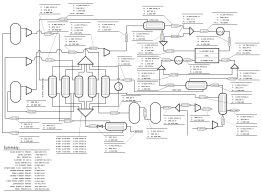

In [14]:
display(SVG(m.fs.write_pfd()))

In [15]:
streams_df = m.fs.streams_dataframe()
display(streams_df)

,mass flow (kg/s),mole flow (kmol/s),mole percent Ar (%),mole percent CO2 (%),mole percent H2 (%),mole percent H2O (%),mole percent N2 (%),mole percent O2 (%),pressure (bar),temperature (K),vapor fraction (%),volumetric flow (m**3/s)
feed01,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,489.184396,100.0,104.510707
feed02a,55.850905,3.100198,NaN,NaN,NaN,100.0,NaN,NaN,1.2,837.804027,100.0,179.843508
feed02b,55.850942,3.100198,NaN,NaN,0.0,100.0,NaN,NaN,1.2,837.804027,NaN,179.816147
feed03,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,893.356797,NaN,383.734354
feed04,72.020882,6.200397,NaN,NaN,40.000001,59.999999,NaN,NaN,1.2,929.128108,NaN,399.115451
hstrm01,32.33988,6.200397,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,413.414798
hstrm02,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707403
hstrm03,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,962.166542,NaN,206.707395
hstrm04,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,546.975234,NaN,117.492387
hstrm05,16.16994,3.100198,NaN,NaN,80.000001,19.999999,NaN,NaN,1.2,372.220932,NaN,79.914997


In [16]:
m.fs.write_pfd(fname="soec_standalone_design_point.svg")
streams_df.to_csv("soec_standalone_design_point.csv")

In [17]:
water_heaters = [
    m.fs.water_evaporator01,
    m.fs.water_evaporator02,
    m.fs.water_evaporator03,
    m.fs.water_evaporator04,
    m.fs.water_evaporator05,
    m.fs.water_preheater,
]
cross_flow_exchangers = [
    m.fs.feed_hot_exchanger,
    m.fs.sweep_hot_exchanger,
    m.fs.sweep_medium_exchanger,
]
heaters = [
    m.fs.feed_heater,
    m.fs.sweep_heater
]
flash_vessels = [m.fs.product_flash01,
#                  m.fs.product_flash02,
                 m.fs.product_flash03,
                 m.fs.product_flash04,
                 m.fs.product_flash05,
                ]



compressors = [getattr(m.fs, f"cmp0{i}") for i in range(1,5)]
print(f"Total CapEx: ${pyo.value(m.fs.costing.total_TPC):.2f}MM")
print(f"Contribution from SOEC: ${pyo.value(m.fs.soec_module.costing.total_plant_cost):.2f}MM")
print(f"Contribution from H2 compressors: ${pyo.value(sum([cmp.costing.total_plant_cost for cmp in compressors])):.2f}MM")
print(f"Contribution from H2O compressor: ${pyo.value(m.fs.water_compressor.costing.total_plant_cost):.2f}MM")
print(f"Contribution from trim heaters: ${pyo.value(sum([heater.costing.total_plant_cost for heater in heaters])):.2f}MM")
print(f"Contribution from gas-gas exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in cross_flow_exchangers])):.2f}MM")
print(f"Contribution from gas-water exchangers: ${pyo.value(sum([hx.costing.total_plant_cost for hx in water_heaters])):.2f}MM")
print(f"Contribution from flash vessels: ${pyo.value(sum([flash.costing.total_plant_cost for flash in flash_vessels])):.2f}MM")
print(f"Contribution from heat pump: ${pyo.value(m.fs.heat_pump.costing.total_plant_cost):.2f}MM")
print(f"Contribution from sweep blower: ${pyo.value(m.fs.sweep_blower.costing.total_plant_cost):.2f}MM")
print(f"Contribution from water feed & treatment systems: ${pyo.value(m.fs.costing.water_systems_cost):.2f}MM")
print(f"Contribution from accessory electric equipment: ${pyo.value(m.fs.costing.accessory_electric_plant_cost):.2f}MM")
print(f"Contribution from instrumentation and controls: ${pyo.value(m.fs.costing.instrumentation_and_control_cost):.2f}MM")
print(f"Contribution from improvements to site: ${pyo.value(m.fs.costing.improvements_to_site_cost):.2f}MM")
print(f"Contribution from buildings and structures: ${pyo.value(m.fs.costing.buildings_and_structures_cost):.2f}MM")

print("\n")
print("------------------------------------------")
print("Fixed Costs for Optimized Design")
print("------------------------------------------")

# tpc = pyo.value(m.fs.costing.total_TPC)
# tasc = tpc*1.21*1.093
# ac = tasc*0.0707
assert pyo.value(m.fs.costing.total_TPC) == pytest.approx(439.5608, rel=1e-3)
print(f"TPC = {pyo.value(m.fs.costing.total_TPC)}")
print(f"TASC = {pyo.value(m.fs.costing.total_as_spent_cost)}")
assert pyo.value(m.fs.costing.total_annualized_cost) == pytest.approx(41.100, rel=1e-3)
print(f"Annualized TASC (MM$/yr) = {pyo.value(m.fs.costing.total_annualized_cost)}")

# Parameters
# n_op = 6.3
# hourly_rate = 38.50
# labor_burden = 30

# Fixed O&M components
# annual_op_labor = n_op * hourly_rate * 8760 * (1 - labor_burden/100)/1e6
# maint_labor = tpc * 0.4 * 0.019 
# maint_material = tpc * 0.6 * 0.019
# admin_labor = 0.25*(annual_op_labor + maint_labor)
# prop_tax_ins = 0.02*tpc
# soec_replace = pyo.value(4.2765*m.fs.soec_module.number_cells)/1e6

print("Fixed O&M Costs")
print(f"annual_op_labor (MM$/yr) = {pyo.value(m.fs.costing.annual_operating_labor_cost)}")
print(f"maint_labor (MM$/yr) = {pyo.value(m.fs.costing.maintenance_labor_cost)}")
print(f"maint_material (MM$/yr) = {pyo.value(m.fs.costing.maintenance_material_cost)}")
print(f"admin_labor (MM$/yr) = {pyo.value(m.fs.costing.admin_and_support_labor_cost)}")
print(f"prop_tax_ins (MM$/yr) = {pyo.value(m.fs.costing.property_tax_and_insurance_cost)}")
print(f"soec_replace (MM$/yr) = {pyo.value(m.fs.soec_module.costing.annual_soec_replacement_cost)}")
# total_fixed = annual_op_labor + maint_labor + maint_material + admin_labor + prop_tax_ins + soec_replace
print(f"Annualized Fixed O&M (MM$/year) = {pyo.value(m.fs.costing.annual_fixed_operations_and_maintenance_cost)}")
fixed_cost_per_h2 = pyo.value(
    m.fs.costing.total_annualized_cost
    + m.fs.costing.annual_fixed_operations_and_maintenance_cost
)/24/365.2425/5/60/60*1e6
print(f"Fixed ($/kg h2) = {fixed_cost_per_h2}")

print(f"Annual water cost MM$ {pyo.value(m.fs.costing.annual_water_cost)}")
print(f"water cost $/kg h2 {pyo.value(m.fs.costing.annual_water_cost)/24/365/5/60/60*1e6}")

Total CapEx: $439.49MM
Contribution from SOEC: $72.84MM
Contribution from H2 compressors: $25.80MM
Contribution from H2O compressor: $45.96MM
Contribution from trim heaters: $25.18MM
Contribution from gas-gas exchangers: $16.46MM
Contribution from gas-water exchangers: $32.88MM
Contribution from flash vessels: $0.57MM
Contribution from heat pump: $34.77MM
Contribution from sweep blower: $2.88MM
Contribution from water feed & treatment systems: $31.12MM
Contribution from accessory electric equipment: $93.02MM
Contribution from instrumentation and controls: $23.19MM
Contribution from improvements to site: $27.48MM
Contribution from buildings and structures: $7.34MM


------------------------------------------
Fixed Costs for Optimized Design
------------------------------------------
TPC = 439.4946977432949
TASC = 581.2449226064399
Annualized TASC (MM$/yr) = 41.0940160282753
Fixed O&M Costs
annual_op_labor (MM$/yr) = 2.7639945332999996
maint_labor (MM$/yr) = 3.3401597028490415
maint_mate

In [18]:
assert m.fs.tags_output['total_electric_power_per_h2'].value == pytest.approx(143.998, rel=1e-3)
assert m.fs.tags_input['water_utilization'].value == pytest.approx(66.667, rel=1e-3)

In [19]:
print(m.fs.tags_output['total_electric_power_per_h2'].value)
print(m.fs.tags_input['water_utilization'].value)
m.fs.soec_module.number_cells.pprint()

143.95128428572792
66.66666763175792
number_cells : Number of cells in SOC module
    Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1087915.2961547659 :  None : False : False :  Reals


In [20]:
for hx in water_heaters + cross_flow_exchangers:
    print(f"{hx.name}: {pyo.value(hx.area)}")

fs.water_evaporator01: 2018
fs.water_evaporator02: 1632.2888589890003
fs.water_evaporator03: 1513.807151561463
fs.water_evaporator04: 5245
fs.water_evaporator05: 5267.255035553301
fs.water_preheater: 1748.043371215905
fs.feed_hot_exchanger: 4639.917489997705
fs.sweep_hot_exchanger: 5521.965254400572
fs.sweep_medium_exchanger: 8511.84924858721


In [21]:
for flash in flash_vessels:
    flash.diameter.fix()
    flash.length.fix()
    flash.length_diameter_heuristic.deactivate()
    flash.capacity_heuristic.deactivate()

for hx in water_heaters + cross_flow_exchangers:
    hx.area.fix()

for heater in heaters:
    heater.max_heat_duty.fix()
    
for blk in m.fs.block_data_objects():
    if hasattr(blk, "costing"):
        blk.costing.deactivate()

# Need the parent costing block for variable cost
m.fs.costing.activate()
m.fs.costing.total_TPC.fix()
m.fs.costing.total_TPC_eqn.deactivate()
    
m.fs.soec_module.number_cells.fix()
m.fs.max_raw_water_withdrawal.fix()
m.fs.heat_pump.max_heat_duty.fix()

m.fs.obj.deactivate()
m.fs.obj2 = pyo.Objective(
        expr = 0.1*(
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )
m.fs.obj3 = pyo.Objective(
        expr = 10*(
            m.fs.costing.annual_electricity_cost 
            + m.fs.costing.annual_water_cost
            + m.fs.costing.annual_air_cost
        )
    )  


In [22]:
run_samples = True
df = None
prod_vec = np.linspace(5, 1, 33)

if run_samples:
    i=1
    df = pd.DataFrame(columns=m.fs.tags_output.table_heading())
    for prod in prod_vec:
        print(prod)
        solved = False
        m.fs.obj2.activate()
        m.fs.obj3.deactivate()
        m.fs.h2_mass_production.fix(prod)
        res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 250, "halt_on_ampl_error":"no"})
        solved = (res.solver.termination_condition == pyo.TerminationCondition.optimal
                  and res.solver.status == pyo.SolverStatus.ok)
        if not solved:
            m.fs.obj2.deactivate()
            m.fs.obj3.activate()
            res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 250, "halt_on_ampl_error":"no"})
            assert res.solver.termination_condition == pyo.TerminationCondition.optimal
            assert res.solver.status == pyo.SolverStatus.ok
#             solved = (res.solver.termination_condition == pyo.TerminationCondition.optimal
#                       and res.solver.status == pyo.SolverStatus.ok)
#             if not solved:
#                 m.fs.obj3.deactivate()
#                 m.fs.obj4.activate()
#                 res = solver.solve(m, tee=True, options={"tol": 1e-6, "max_iter": 150, "halt_on_ampl_error":"no"})

        df.loc[i] = m.fs.tags_output.table_row(numeric=True)
        i += 1


5.0
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmplk0zhlv__ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmplk0zhlv__ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

  66  4.6498643e+01 4.57e-05 6.07e+05  -1.0 1.78e+02    -  5.68e-01 7.06e-03h  8
  67  4.6498644e+01 4.56e-05 6.56e+05  -1.0 1.59e+02    -  8.12e-01 7.20e-03h  8
  68  4.6498646e+01 4.54e-05 6.92e+05  -1.0 1.67e+02    -  6.10e-01 7.10e-03h  8
  69  4.6498648e+01 4.58e-05 7.40e+05  -1.0 1.51e+02    -  8.77e-01 1.45e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  4.6498653e+01 4.52e-05 7.74e+05  -1.0 1.55e+02    -  6.68e-01 1.43e-02h  7
  71  4.6498769e+01 4.35e-03 5.81e+04  -1.0 1.40e+02    -  9.78e-01 9.29e-01w  1
  72  4.6498867e+01 9.71e-03 2.81e+05  -1.0 7.96e+01    -  9.61e-01 6.94e-01w  1
  73  4.6498856e+01 3.50e-02 5.50e+05  -1.0 1.85e+02    -  6.73e-01 5.42e-01w  1
  74  4.6498654e+01 4.56e-05 8.30e+05  -1.0 6.50e+01    -  9.78e-01 1.45e-02h  6
  75  4.6498659e+01 4.49e-05 8.70e+05  -1.0 1.39e+02    -  7.51e-01 1.44e-02h  7
  76  4.6498661e+01 4.53e-05 9.28e+05  -1.0 1.26e+02    -  1.00e+00 1.46e-02h  7
  77  4.6498664e+01 4.49e-05

 158  4.6498875e+01 4.62e-05 2.98e+13  -1.0 5.78e+01    -  1.00e+00 1.97e-02h  6
 159  4.6498875e+01 4.62e-05 4.67e+13  -1.0 5.78e+01    -  1.00e+00 1.98e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  4.6498875e+01 4.61e-05 7.25e+13  -1.0 5.77e+01    -  1.00e+00 1.99e-02h  6
 161  4.6498876e+01 4.61e-05 1.12e+14  -1.0 5.75e+01    -  1.00e+00 2.00e-02h  6
 162  4.6498876e+01 4.60e-05 1.71e+14  -1.0 5.72e+01    -  1.00e+00 2.02e-02h  6
 163  4.6498876e+01 4.60e-05 2.60e+14  -1.0 5.71e+01    -  1.00e+00 2.04e-02h  6
 164  4.6498882e+01 9.76e-04 1.36e+14  -1.0 5.71e+01    -  1.00e+00 6.58e-01w  1
 165  4.6498898e+01 4.14e-03 3.61e+15  -1.0 7.85e+01    -  8.81e-02 8.61e-01w  1
 166  4.6498907e+01 3.06e-03 2.61e+15  -1.0 1.63e+01    -  3.08e-01 2.77e-01w  1
 167  4.6498876e+01 4.60e-05 3.90e+14  -1.0 3.84e+00    -  1.00e+00 2.06e-02h  5
 168  4.6498876e+01 4.60e-05 5.79e+14  -1.0 5.74e+01    -  1.00e+00 2.08e-02h  6
 169  4.6498876e+01 4.61e-05

    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp5csu7d_q_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp5csu7d_q_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See h

   2  4.5436281e+01 6.59e-02 2.02e+01  -1.0 2.77e+02    -  3.97e-01 8.02e-01h  1
   3  4.5386701e+01 2.63e-02 5.65e+01  -1.0 7.83e+00  -4.5 9.90e-01 6.00e-01h  1
   4  4.5355452e+01 2.96e-03 5.89e+01  -1.0 1.72e+02    -  8.16e-01 9.90e-01h  1
   5  4.5354621e+01 2.00e-03 9.28e+03  -1.0 2.50e+02    -  9.90e-01 6.96e-01h  1
   6  4.5354283e+01 3.88e-04 1.10e+02  -1.0 7.42e+01    -  9.90e-01 9.90e-01h  1
   7  4.5354251e+01 3.92e-06 1.00e+05  -1.0 3.36e+00    -  1.00e+00 9.90e-01h  1
   8  4.5354249e+01 2.70e-07 4.12e+04  -1.0 1.20e-01  -5.0 1.00e+00 1.00e+00h  1
   9  4.5354250e+01 8.53e-08 1.14e+06  -1.0 2.60e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.5354245e+01 6.04e-07 2.33e+03  -1.0 2.12e-01  -5.4 1.00e+00 1.00e+00h  1
  11  4.5354207e+01 7.64e-08 3.42e+08  -3.8 7.41e-01    -  9.91e-01 1.00e+00h  1
  12  4.5352331e+01 1.81e-04 1.66e+08  -3.8 4.43e-01  -3.2 5.38e-01 1.00e+00f  1
Reallocating memory for MA57

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.4171457e+01 6.16e-03 3.35e+03  -5.7 3.09e+02    -  4.19e-01 4.59e-01h  1
  31  4.4170514e+01 6.67e-03 8.88e+04  -5.7 1.52e+02    -  7.79e-01 8.47e-02h  1
  32  4.4169313e+01 1.16e-04 7.31e-01  -5.7 3.75e+01    -  1.00e+00 1.00e+00h  1
  33  4.4169233e+01 5.40e-06 1.05e+02  -5.7 9.01e-01    -  9.07e-01 1.00e+00h  1
  34  4.4169215e+01 1.07e-06 3.52e-02  -5.7 7.56e-01    -  1.00e+00 1.00e+00h  1
  35  4.4169215e+01 1.82e-12 3.97e-06  -5.7 1.60e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 35

                                   (scaled)                 (unscaled)
Objective...............:   4.4169215420112323e+01    4.4169215420112323e+01
Dual infeasibility......:   3.9682594926745438e-06    4.0694651615504824e-06
Constraint violation....:   1.8189894035458565e-12    1.8189894035458565e-12
Complementarity.........:   1.8449169180977212e-06    1.8449169180977212e-06
Overall NLP error......

4.5
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpdu7116cj_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpdu7116cj_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

   2  4.0741458e+01 3.70e-02 2.75e+02  -1.0 1.99e+01  -4.0 6.20e-01 8.83e-01h  1
   3  4.0776087e+01 6.16e-02 3.01e+03  -1.0 2.15e+02    -  9.58e-01 9.88e-01h  1
   4  4.0776185e+01 2.74e-03 2.84e+05  -1.0 4.06e-03   7.8 9.90e-01 1.00e+00f  1
   5  4.0774379e+01 2.09e-03 1.05e+10  -1.0 9.74e-01   7.4 9.90e-01 8.69e-01h  1
   6  4.0774151e+01 5.76e-05 1.20e+09  -1.0 1.40e-01   6.9 9.91e-01 9.89e-01h  1
   7  4.0774149e+01 5.62e-07 1.29e+07  -1.0 1.66e-03   6.4 1.00e+00 9.90e-01h  1
   8  4.0774149e+01 1.85e-12 1.61e+02  -1.0 1.59e-05   5.9 1.00e+00 1.00e+00h  1
   9  4.0774149e+01 1.80e-12 9.13e-03  -3.8 1.53e-08   5.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  4.0774149e+01 1.29e-12 4.41e-03  -7.0 4.59e-08   5.0 1.00e+00 1.00e+00h  1
  11  4.0774149e+01 1.84e-12 4.40e-03  -7.0 1.38e-07   4.5 1.00e+00 1.00e+00h  1
  12  4.0774149e+01 1.29e-12 4.40e-03  -7.0 4.13e-07   4.0 1.00e+00 1.00e+00h  1
  13  4.0774149e+01 1.10e-12

   9  3.9589910e+01 2.47e-10 1.72e+03  -2.5 1.73e-04   1.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.9589906e+01 1.51e-10 1.75e+02  -2.5 5.18e-04   0.9 1.00e+00 1.00e+00f  1
  11  3.9589892e+01 4.58e-09 1.94e+09  -3.8 1.55e-03   0.5 2.12e-01 1.00e+00H  1
  12  3.9589886e+01 4.01e-09 1.70e+09  -3.8 4.64e-03  -0.0 1.00e+00 1.25e-01h  4
  13  3.9589882e+01 3.88e-09 1.65e+09  -3.8 1.39e-02  -0.5 1.00e+00 3.12e-02h  6
  14  3.9589485e+01 9.32e-07 3.74e+03  -3.8 4.18e-02  -1.0 1.00e+00 1.00e+00f  1
  15  3.9588297e+01 8.35e-06 3.09e+01  -3.8 1.25e-01  -1.5 1.00e+00 1.00e+00h  1
  16  3.9584758e+01 7.46e-05 4.19e+00  -3.8 3.73e-01  -1.9 1.00e+00 1.00e+00h  1
  17  3.9583436e+01 1.07e-05 2.43e+00  -3.8 1.40e-01  -1.5 1.00e+00 1.00e+00h  1
  18  3.9579491e+01 9.48e-05 5.60e+00  -3.8 4.17e-01  -2.0 1.00e+00 1.00e+00h  1
  19  3.9567875e+01 8.43e-04 5.25e+01  -3.8 1.24e+00  -2.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

   8  3.8536372e+01 1.13e-01 5.85e+05  -1.0 9.46e+02    -  6.13e-01 3.59e-02f  4
   9  3.8534918e+01 1.10e-01 8.68e+05  -1.0 7.07e+02    -  3.49e-01 2.58e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.8533125e+01 1.06e-01 1.72e+06  -1.0 5.63e+02    -  9.97e-01 3.61e-02h  5
  11  3.8494119e+01 4.14e-03 5.33e+05  -1.0 3.41e+02    -  7.21e-01 9.88e-01H  1
Reallocating memory for MA57: lfact (250792)
  12  3.8495193e+01 6.72e-03 1.12e+06  -1.0 8.73e+00    -  1.00e+00 9.86e-01h  1
  13  3.8494642e+01 2.87e-04 2.84e+06  -1.0 3.31e-01    -  1.00e+00 1.00e+00h  1
  14  3.8494496e+01 3.76e-04 1.35e+07  -1.0 2.45e+00    -  1.00e+00 1.00e+00f  1
  15  3.8494903e+01 8.73e-04 4.87e+07  -1.0 1.50e+00  -2.7 2.59e-01 3.40e-01f  2
  16  3.8495180e+01 9.69e-05 3.46e+04  -1.0 1.28e-01  -1.3 1.00e+00 1.00e+00f  1
  17  3.8495133e+01 2.01e-06 2.47e+09  -2.5 1.61e-02   0.9 9.20e-01 1.00e+00h  1
  18  3.8495117e+01 1.60e-09 1.24e+01  -2.5 1.67e-03   0.4 1.00e

   2  3.7287989e+01 6.54e-02 4.07e+02  -1.0 2.47e+02    -  4.50e-01 8.40e-01h  1
   3  3.7289685e+01 4.99e-02 5.87e+04  -1.0 1.05e+01  -4.0 9.77e-01 3.90e-01h  1
   4  3.7317159e+01 6.48e-02 1.31e+05  -1.0 5.79e+02    -  6.25e-01 2.48e-01h  3
   5  3.7328513e+01 6.97e-02 3.17e+05  -1.0 8.95e+02    -  9.89e-01 6.47e-02h  4
Reallocating memory for MA57: lfact (250483)
   6  3.7406785e+01 1.68e-01 7.76e+03  -1.0 6.94e+02    -  9.90e-01 9.90e-01H  1
   7  3.7404553e+01 1.61e-01 1.19e+05  -1.0 8.18e+02    -  2.25e-01 4.24e-02f  4
   8  3.7402377e+01 1.55e-01 4.55e+05  -1.0 9.09e+02    -  5.24e-01 3.49e-02f  4
   9  3.7398501e+01 1.46e-01 7.44e+05  -1.0 7.40e+02    -  4.88e-01 5.92e-02h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  3.7397518e+01 1.43e-01 1.23e+06  -1.0 5.08e+02    -  6.97e-01 2.25e-02h  6
  11  3.7397514e+01 1.43e-01 2.02e+06  -1.0 4.23e+02    -  1.00e+00 1.04e-04h 14
  12  3.7364862e+01 6.70e-03 4.36e+05  -1.0 3.51e+02    -  9.47e

  96r 3.7195788e+01 6.14e-02 1.00e+03  -1.2 0.00e+00    -  0.00e+00 2.60e-07R  3
  97r 3.7195921e+01 6.07e-02 1.00e+03  -1.2 1.03e+04    -  4.43e-05 1.05e-05f  1
  98r 3.7195657e+01 2.19e-02 2.55e+03  -1.2 2.67e+02    -  2.09e-02 6.69e-04f  1
  99  3.7196519e+01 1.04e-05 2.10e+00  -5.7 3.27e+00    -  9.54e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7196117e+01 4.95e-05 1.58e+02  -5.7 1.93e+00    -  9.97e-01 1.00e+00h  1
 101  3.7196091e+01 4.60e-05 6.81e+05  -5.7 1.27e+00    -  1.00e+00 8.00e-02h  1
 102  3.7195842e+01 4.23e-06 6.31e+01  -5.7 1.17e+00    -  1.00e+00 1.00e+00f  1
 103  3.7195842e+01 1.24e-11 4.43e-05  -5.7 1.17e-03    -  1.00e+00 1.00e+00h  1
 104  3.7195826e+01 4.27e-07 4.57e+01  -7.0 1.45e-01    -  1.00e+00 1.00e+00h  1
 105  3.7195826e+01 2.44e-10 2.36e-04  -7.0 7.35e-03    -  1.00e+00 1.00e+00h  1
 106  3.7195826e+01 6.82e-13 2.93e-08  -7.0 2.19e-07    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 1

3.75
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp6qfw36gv_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp6qfw36gv_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  Al

  67  3.4903009e+01 4.67e-01 7.63e+04  -3.8 3.52e+01  -5.2 6.61e-01 6.56e-01h  1
  68  3.4890156e+01 9.65e-02 1.31e+04  -3.8 1.14e+01  -4.8 1.00e+00 1.00e+00h  1
  69  3.4889432e+01 8.81e-02 2.32e+06  -3.8 5.84e+01  -5.3 6.37e-01 3.58e-02H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.4889189e+01 6.47e-03 1.93e+06  -3.8 1.67e+02    -  2.09e-01 1.00e+00f  1
  71  3.4887476e+01 2.59e-02 1.67e+06  -3.8 3.58e+03    -  1.38e-01 1.54e-01h  1
  72  3.4886132e+01 2.70e-02 1.39e+06  -3.8 9.84e+03    -  1.70e-01 4.59e-02h  1
  73  3.4886050e+01 2.67e-02 3.15e+06  -3.8 1.57e+02  -5.8 7.74e-02 1.10e-02h  2
  74  3.4885686e+01 1.47e-03 2.48e+03  -3.8 5.43e+01    -  1.00e+00 1.00e+00h  1
  75  3.4885329e+01 3.45e-03 5.98e+06  -3.8 2.39e+01    -  1.00e+00 4.47e-01h  2
  76  3.4884060e+01 3.32e-03 2.55e+04  -3.8 1.15e+01    -  1.00e+00 1.00e+00h  1
  77  3.4884692e+01 1.01e-02 2.31e+07  -3.8 4.35e+00    -  5.29e-02 9.93e-01h  1
  78  3.4882305e+01 9.44e-03

  14  3.3947020e+01 1.00e-03 3.65e+08  -1.0 3.68e-01  -0.0 9.90e-01 0.00e+00S  2
  15  3.3947002e+01 1.65e-05 1.68e+08  -1.0 6.91e-02  -0.5 9.90e-01 1.00e+00h  1
  16  3.3946931e+01 8.77e-05 2.92e+09  -1.0 1.89e+01    -  2.09e-01 5.15e-02f  3
  17  3.3946927e+01 3.83e-08 3.64e+07  -1.0 2.26e-03   1.7 9.98e-01 1.00e+00h  1
  18  3.3946923e+01 4.99e-08 1.89e+01  -1.0 2.78e-03   1.3 1.00e+00 1.00e+00f  1
  19  3.3943112e+01 7.79e-05 5.56e+09  -5.7 1.68e+01    -  8.49e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  3.3809602e+01 1.06e-01 4.84e+09  -5.7 1.43e+03    -  1.29e-01 3.61e-01f  1
  21  3.3809628e+01 1.03e-01 4.85e+09  -5.7 2.80e+00   0.8 4.94e-05 3.39e-02h  1
  22  3.3812047e+01 8.63e-02 4.88e+09  -5.7 2.54e+00   0.3 1.32e-04 1.60e-01h  1
  23  3.3812098e+01 8.59e-02 2.41e+09  -5.7 2.99e+00  -0.2 4.97e-01 4.73e-03h  1
  24  3.3814373e+01 6.75e-02 2.26e+09  -5.7 2.88e+00  -0.6 6.17e-02 2.14e-01h  1
  25  3.3814581e+01 6.65e-02

3.5
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmp3rs2r3ok_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmp3rs2r3ok_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All

3.375
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpz05cwj23_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpz05cwj23_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  A

  66  3.1467000e+01 1.19e-02 2.57e+06  -2.5 3.05e+00  -3.3 1.00e+00 1.00e+00w  1
  67  3.1470806e+01 1.33e-02 1.31e+06  -2.5 3.82e+00  -2.9 6.69e-01 7.20e-01w  1
  68  3.1460052e+01 1.13e-04 3.51e+08  -2.5 1.05e+01  -3.3 9.49e-01 3.12e-02h  5
  69  3.1460059e+01 1.12e-04 3.91e+08  -2.5 1.12e+00  -2.9 1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  3.1460064e+01 1.12e-04 3.93e+08  -2.5 1.36e+00  -3.4 1.00e+00 1.95e-03h 10
  71  3.1460076e+01 1.12e-04 4.03e+08  -2.5 3.51e+00  -3.9 1.00e+00 1.95e-03h 10
  72  3.1460089e+01 1.12e-04 3.95e+08  -2.5 3.82e+00  -4.3 1.00e+00 1.95e-03h 10
  73  3.1460165e+01 1.13e-04 4.05e+08  -2.5 5.97e+00    -  1.00e+00 7.81e-03h  8
  74  3.1461404e+01 8.03e-04 3.48e+08  -2.5 5.99e+00    -  1.00e+00 1.25e-01h  4
  75  3.1461548e+01 8.00e-04 4.50e+08  -2.5 5.53e+00  -4.8 1.00e+00 1.56e-02h  7
  76  3.1461588e+01 7.98e-04 4.46e+08  -2.5 7.08e+00    -  9.91e-01 3.91e-03h  9
  77  3.1461597e+01 7.97e-04

 158  3.1379395e+01 5.47e-05 2.05e+06  -5.7 3.95e-01  -4.0 1.00e+00 2.57e-01f  1
 159  3.1378251e+01 9.00e-04 1.31e+06  -5.7 1.71e+00  -4.4 8.28e-01 6.23e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  3.1378158e+01 1.98e-03 7.36e+08  -5.7 2.65e+00  -4.9 2.40e-03 3.23e-01h  1
 161  3.1378100e+01 1.63e-03 5.79e+08  -5.7 1.16e+00  -5.4 1.00e+00 2.13e-01f  1
 162  3.1378079e+01 1.64e-03 4.00e+08  -5.7 1.15e+00  -5.9 4.23e-01 3.08e-01h  1
 163  3.1378056e+01 1.77e-02 2.58e+07  -5.7 2.23e+00  -6.4 1.00e+00 9.35e-01f  1
 164  3.1377927e+01 1.72e-02 2.51e+07  -5.7 1.71e+03    -  1.06e-01 2.75e-02h  1
 165  3.1377939e+01 1.90e-02 2.51e+07  -5.7 8.17e+03    -  5.02e-03 3.69e-04h  7
 166  3.1377884e+01 2.06e-02 2.47e+07  -5.7 1.24e+03    -  8.07e-01 1.50e-02h  1
 167  3.1377823e+01 1.98e-02 2.38e+07  -5.7 5.77e+02    -  1.00e+00 3.77e-02h  1
 168  3.1377794e+01 3.36e-05 1.26e+03  -5.7 2.29e+00    -  1.00e+00 1.00e+00h  1
 169  3.1377379e+01 4.64e-03

  38  3.0297193e+01 1.49e-03 3.91e+08  -3.8 1.24e+00  -3.4 4.79e-01 8.48e-01h  1
  39  3.0295799e+01 6.45e-04 2.18e+07  -3.8 6.98e-01  -3.0 9.61e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  3.0290790e+01 3.89e-03 1.77e+07  -3.8 1.65e+03    -  2.25e-01 5.33e-02h  1
  41  3.0213872e+01 3.68e+00 8.80e+06  -3.8 5.64e+02    -  5.22e-02 3.49e-01h  1
  42  3.0232272e+01 1.96e+00 3.34e+06  -3.8 4.00e+01    -  5.80e-01 5.23e-01h  1
  43  3.0217804e+01 5.51e-01 5.65e+05  -3.8 1.65e+02    -  1.00e+00 8.25e-01h  1
  44  3.0217264e+01 2.85e-01 5.77e+05  -3.8 3.96e+01    -  8.89e-01 4.82e-01h  1
  45  3.0217019e+01 4.78e-03 1.05e+03  -3.8 6.81e+01    -  1.00e+00 1.00e+00h  1
  46  3.0216711e+01 1.45e-04 1.17e+06  -3.8 2.15e+00    -  6.75e-01 1.00e+00h  1
  47  3.0216562e+01 1.62e-04 7.99e+06  -3.8 7.74e+00    -  1.00e+00 4.56e-01H  1
  48  3.0216550e+01 1.60e-04 9.62e+06  -3.8 2.62e+01    -  7.25e-01 2.49e-02f  6
  49  3.0216537e+01 1.60e-04

  24  2.9377375e+01 7.30e-06 3.20e+09  -1.0 7.67e+00    -  1.00e+00 3.91e-03h  9
  25  2.9377375e+01 7.29e-06 3.54e+09  -1.0 7.77e+00    -  1.00e+00 4.88e-04h 12
  26  2.9377375e+01 7.29e-06 3.19e+09  -1.0 5.92e+00    -  1.00e+00 2.44e-04h 13
  27  2.9377375e+01 7.29e-06 3.52e+09  -1.0 6.83e+00    -  1.00e+00 1.53e-05h 17
  28  2.9377373e+01 7.09e-06 3.02e+09  -1.0 7.00e+00    -  1.00e+00 6.25e-02h  5
  29  2.9377447e+01 3.01e-04 6.86e+06  -1.0 9.70e-01  -2.8 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.9377958e+01 7.68e-04 1.78e+09  -1.0 3.81e+00  -3.3 6.86e-01 1.00e+00w  1
  31  2.9376650e+01 1.79e-03 9.19e+09  -1.0 2.64e+01    -  4.52e-01 1.43e-01w  1
  32  2.9377376e+01 6.94e-06 3.59e+09  -1.0 1.26e+02    -  1.00e+00 3.12e-02h  5
  33  2.9377377e+01 6.87e-06 3.28e+09  -1.0 7.82e+00    -  1.00e+00 6.25e-02h  5
  34  2.9377366e+01 6.69e-06 3.72e+09  -1.0 1.56e+00  -3.7 1.00e+00 6.25e-02h  5
  35  2.9377302e+01 1.17e-05

 117  2.9377452e+01 4.95e-05 8.45e+09  -1.0 1.87e+01    -  1.00e+00 6.25e-02h  5
 118  2.9377332e+01 5.72e-04 4.19e+07  -1.0 1.51e+01    -  9.47e-01 1.00e+00w  1
 119  2.9377450e+01 3.11e-04 7.30e+07  -1.0 9.72e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  2.9377159e+01 2.58e-03 1.13e+10  -1.0 2.70e+00  -2.9 6.64e-01 1.00e+00w  1
 121  2.9377444e+01 4.66e-05 8.62e+09  -1.0 3.98e+07    -  9.47e-01 6.25e-02h  4
 122  2.9377335e+01 4.27e-05 8.83e+09  -1.0 4.05e-01  -2.5 1.00e+00 1.25e-01h  4
 123  2.9377342e+01 4.27e-05 9.85e+09  -1.0 2.91e+02    -  2.05e-01 4.29e-04h 12
 124  2.9377315e+01 4.25e-05 1.07e+10  -1.0 8.60e+01    -  1.00e+00 4.42e-03h  7
 125  2.9377302e+01 4.03e-05 1.06e+10  -1.0 1.37e+01    -  1.00e+00 6.25e-02h  5
 126  2.9377256e+01 3.82e-05 1.10e+10  -1.0 3.90e-01  -3.0 1.00e+00 6.25e-02h  5
 127  2.9377269e+01 3.70e-05 1.25e+10  -1.0 2.53e+01    -  1.00e+00 3.12e-02h  6
 128  2.9377284e+01 3.70e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210  2.9156770e+01 2.76e-01 2.36e+09  -2.5 4.06e+01  -1.4 2.45e-01 3.48e-02h  1
 211  2.9162142e+01 2.38e-01 1.92e+09  -2.5 4.94e+01  -1.8 1.87e-01 1.39e-01h  1
 212  2.9190596e+01 1.79e-01 1.77e+09  -2.5 4.66e+01  -2.3 6.07e-02 1.00e+00h  1
 213  2.9179698e+01 1.61e-03 3.82e+08  -2.5 1.44e+00  -2.8 7.84e-01 1.00e+00h  1
 214  2.9141053e+01 2.14e-02 3.56e+04  -2.5 6.25e+00  -3.3 1.00e+00 7.88e-01h  1
 215  2.9138876e+01 1.77e-01 1.89e+07  -2.5 5.82e+02    -  8.97e-01 3.51e-01f  1
 216  2.9132243e+01 1.11e-02 5.77e+04  -2.5 6.09e+01    -  1.00e+00 1.00e+00h  1
 217  2.9133099e+01 6.19e-04 2.58e+02  -2.5 2.94e-01  -3.7 1.00e+00 1.00e+00h  1
 218  2.9130636e+01 1.62e-03 1.86e+06  -3.8 2.21e+03    -  6.93e-02 7.10e-02h  1
 219  2.9121785e+01 4.58e-03 1.65e+08  -3.8 2.17e+02    -  5.63e-01 7.26e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  2.9116449e+01 2.13e-02

  19  2.8141689e+01 4.79e-02 1.51e+07  -1.7 1.20e+01   0.8 5.85e-03 1.07e-03h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  2.8141718e+01 4.78e-02 2.01e+07  -1.7 8.55e+00   1.2 4.43e-03 1.06e-03h  3
  21  2.8141745e+01 4.78e-02 3.11e+07  -1.7 4.93e+00   1.6 1.62e-02 1.19e-03h  3
  22  2.8141880e+01 4.74e-02 3.05e+07  -1.7 1.88e+00   2.1 7.07e-03 7.90e-03h  1
  23  2.8141880e+01 4.74e-02 3.05e+07  -1.7 1.85e+00   7.0 1.38e-05 1.46e-04h  1
  24r 2.8141880e+01 4.74e-02 1.00e+03  -1.3 0.00e+00   6.5 0.00e+00 4.63e-07R  3
  25r 2.8143298e+01 1.21e-02 3.59e+03  -1.3 5.24e+02    -  1.20e-02 9.84e-04f  1
  26  2.8143302e+01 1.21e-02 3.15e+05  -1.7 4.78e+01    -  7.35e-01 7.89e-05f  1
  27  2.8142391e+01 4.25e-04 2.23e+05  -1.7 2.12e+01    -  4.65e-01 9.91e-01h  1
  28  2.8142950e+01 4.87e-04 2.22e+05  -1.7 3.49e+00    -  9.90e-01 9.95e-01h  1
  29  2.8168378e+01 1.62e-04 4.30e+07  -1.7 1.18e+02    -  9.90e-01 1.00e+00H  1
iter    objective    inf_pr 


Using option file "C:\Users\cptda\AppData\Local\Temp\tmphsyhvzov_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran c

  69  2.7083824e+01 1.08e-03 5.86e+10  -1.0 4.10e+02    -  9.70e-02 1.20e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.7085690e+01 2.83e-03 8.83e+09  -1.0 7.06e-01  -0.6 7.04e-02 1.00e+00w  1
  71  2.7085525e+01 1.91e-05 1.20e+06  -1.0 1.03e-01  -1.1 1.00e+00 1.00e+00h  1
  72  2.7086195e+01 2.23e-03 3.21e+07  -1.0 5.82e-01  -0.6 9.54e-01 1.00e+00f  1
  73  2.7086361e+01 1.73e-03 1.27e+08  -1.0 3.69e-01  -1.1 7.70e-01 2.25e-01f  2
  74  2.7085794e+01 1.28e-04 7.40e+03  -1.0 3.06e-01  -1.6 1.00e+00 1.00e+00f  1
  75  2.7085224e+01 1.02e-05 1.38e+10  -3.8 5.13e-02  -1.2 6.71e-01 1.00e+00h  1
  76  2.7085039e+01 2.43e-05 7.86e+09  -3.8 9.16e-01  -1.6 4.35e-01 4.86e-02h  2
  77  2.7080772e+01 1.57e-04 1.07e+09  -3.8 4.23e-01  -2.1 8.63e-01 1.00e+00h  1
  78  2.7078716e+01 6.35e-04 9.35e+08  -3.8 1.74e+01  -2.6 1.29e-01 8.96e-02H  1
  79  2.7044152e+01 5.74e-03 3.26e+08  -3.8 4.06e+00  -3.1 6.54e-01 8.94e-01h  1
iter    objective    inf_pr 

 161  2.6730655e+01 2.25e+00 1.04e+07  -5.7 3.04e+01  -2.9 2.15e-02 2.23e-03h  1
 162  2.6730637e+01 2.07e+00 9.55e+06  -5.7 1.10e+02    -  5.60e-04 7.99e-02h  1
 163  2.6730631e+01 2.07e+00 9.55e+06  -5.7 1.39e+02  -2.4 1.34e-03 1.89e-05h  1
 164  2.6732019e+01 1.93e+00 8.87e+06  -5.7 1.73e+02    -  1.19e-02 7.13e-02h  4
 165  2.6730681e+01 1.84e+00 8.49e+06  -5.7 7.58e+01    -  4.52e-02 4.34e-02h  1
 166  2.6730582e+01 1.78e+00 8.21e+06  -5.7 1.01e+02    -  9.75e-02 3.28e-02h  1
 167  2.6730416e+01 7.54e-01 3.47e+06  -5.7 1.12e+02    -  2.07e-01 5.77e-01h  1
 168r 2.6730416e+01 7.54e-01 1.00e+03  -0.1 0.00e+00    -  0.00e+00 3.14e-07R  4
 169r 2.6730737e+01 7.62e-01 1.00e+03  -0.1 2.45e+05    -  6.36e-08 1.81e-07f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 2.6732337e+01 7.55e-01 5.23e+03  -0.1 3.20e+03    -  6.62e-03 5.57e-05f  1
 171r 2.6584267e+01 7.57e-01 5.66e+03  -0.1 1.02e+03    -  2.19e-04 8.30e-03f  1
 172r 2.6581356e+01 7.54e-01

   7  2.5800253e+01 3.87e-01 3.61e+05  -1.0 1.43e+03    -  6.47e-01 3.34e-02f  4
   8  2.5822267e+01 3.74e-01 4.24e+05  -1.0 1.24e+03    -  9.89e-01 8.81e-02h  4
   9  2.5968852e+01 3.47e-02 2.27e+04  -1.0 8.71e+02    -  9.90e-01 9.56e-01H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.5951209e+01 3.39e-02 2.37e+05  -1.0 3.70e+01  -4.0 3.19e-01 5.52e-01h  1
  11  2.5951925e+01 4.01e-02 1.67e+06  -1.0 1.10e+01  -4.5 9.93e-01 9.90e-01h  1
  12  2.5950091e+01 4.36e-02 1.49e+06  -1.0 1.76e+02    -  1.23e-01 1.14e-01f  3
  13  2.5948684e+01 4.57e-02 1.43e+07  -1.0 2.88e+02    -  5.99e-01 5.17e-02f  3
  14  2.5942186e+01 3.91e-02 6.72e+06  -1.0 1.36e+02    -  5.45e-01 5.40e-01H  1
  15  2.5941067e+01 4.63e-03 5.71e+05  -1.0 4.56e+01    -  1.00e+00 9.91e-01h  1
  16  2.5940713e+01 1.86e-03 2.17e+09  -1.0 8.77e+00    -  9.93e-01 6.13e-01h  1
  17  2.5940343e+01 1.50e-04 1.23e+08  -1.0 1.86e+00    -  1.00e+00 9.90e-01h  1
  18  2.5940333e+01 5.65e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.5871052e+01 5.59e-03 5.42e+04  -5.7 4.41e+01  -4.8 2.82e-01 2.21e-02h  1
 101  2.5730710e+01 2.18e-01 4.73e+04  -5.7 9.90e+01  -5.3 9.99e-03 2.02e-01f  1
 102  2.5765350e+01 8.71e-02 4.51e+04  -5.7 1.92e+01  -4.9 6.41e-02 1.00e+00h  1
 103  2.5763484e+01 8.61e-02 7.86e+04  -5.7 2.29e+01  -4.4 9.41e-01 1.09e-02h  1
 104  2.5707169e+01 9.79e-02 5.78e+02  -5.7 2.78e+01  -4.9 1.00e+00 3.06e-01h  1
 105  2.5676076e+01 8.47e-01 1.24e+02  -5.7 4.45e+01  -5.4 5.51e-01 1.00e+00h  1
 106  2.5665347e+01 8.11e-01 7.29e+04  -5.7 1.73e+02  -5.9 1.47e-01 6.43e-02h  1
 107  2.5647186e+01 5.81e-01 1.99e+04  -5.7 4.76e+01  -5.4 1.86e-01 3.21e-01h  1
 108  2.5648097e+01 1.24e-01 1.29e+05  -5.7 3.81e+01  -5.9 1.04e-01 1.00e+00h  1
 109  2.5625824e+01 4.29e-01 2.71e+05  -5.7 6.38e+01  -5.5 1.00e+00 3.28e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  2.5609574e+01 6.07e-01

   1  2.5358110e+01 6.60e-01 1.35e+01  -1.0 4.46e+00  -2.0 3.02e-01 1.81e-01h  1
   2  2.4901149e+01 3.44e-01 1.33e+01  -1.0 1.81e+02    -  5.04e-01 4.77e-01h  1
   3  2.4661548e+01 1.42e-01 6.96e+01  -1.0 1.82e+02    -  5.64e-01 5.84e-01h  1
   4  2.4619253e+01 1.11e-01 3.15e+02  -1.0 3.02e+02    -  4.93e-01 2.83e-01h  1
   5  2.4557379e+01 4.04e-01 1.76e+03  -1.0 5.20e+02    -  5.61e-01 7.05e-01H  1
   6  2.4563446e+01 3.98e-01 1.41e+03  -1.0 5.80e+02    -  1.23e-01 8.51e-02h  4
   7  2.4564416e+01 3.42e-01 1.22e+04  -1.0 9.19e+00  -2.5 9.12e-01 2.18e-01h  1
   8  2.4551132e+01 2.64e-01 3.33e+03  -1.0 9.48e+00  -3.0 8.57e-01 7.86e-01h  1
   9  2.4625598e+01 3.11e-01 3.93e+03  -1.0 2.80e+04    -  2.22e-02 1.25e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.4610496e+01 6.41e-02 2.76e+03  -1.0 3.44e+01  -3.4 9.90e-01 9.90e-01h  1
  11  2.4610618e+01 6.41e-02 4.91e+04  -1.0 2.41e+01  -3.9 2.79e-01 5.06e-03h  7
  12  2.4610697e+01 6.40e-02

  94  2.4434030e+01 9.74e-07 6.93e+04  -2.5 6.52e+00    -  9.97e-01 1.00e+00H  1
  95  2.4434040e+01 9.46e-07 1.20e+09  -2.5 1.64e+01    -  9.97e-01 3.12e-02h  6
  96  2.4434083e+01 2.74e-06 4.01e+05  -2.5 3.30e-02  -4.2 1.00e+00 1.00e+00H  1
  97  2.4434139e+01 1.32e-06 3.42e+03  -2.5 2.15e-02  -2.0 1.00e+00 1.00e+00H  1
  98  2.4434155e+01 5.54e-08 6.15e+01  -2.5 2.80e-03  -1.5 1.00e+00 1.00e+00h  1
  99  2.4431565e+01 2.33e-04 1.18e+08  -3.8 3.51e-01  -2.0 8.99e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.4430344e+01 4.53e-05 1.97e+02  -3.8 1.53e-01  -1.6 1.00e+00 1.00e+00h  1
 101  2.4426926e+01 3.88e-04 3.39e+01  -3.8 4.46e-01  -2.1 1.00e+00 1.00e+00h  1
 102  2.4424611e+01 3.41e-04 1.13e+05  -3.8 1.21e+01  -2.5 3.21e-01 2.53e-01H  1
 103  2.4423918e+01 3.38e-04 5.98e+03  -3.8 2.55e-01  -3.0 1.00e+00 1.00e+00f  1
 104  2.4422108e+01 3.21e-04 1.38e+05  -3.8 1.03e+00  -3.5 7.11e-01 5.81e-01H  1
 105  2.4420278e+01 5.65e-03

   6  2.3350831e+01 1.29e-01 1.31e+04  -1.0 2.39e+03    -  2.20e-01 5.86e-02f  4
   7  2.3363229e+01 1.46e-01 1.87e+04  -1.0 2.34e+03    -  5.34e-01 2.76e-02h  5
   8  2.3369418e+01 1.49e-01 2.26e+04  -1.0 2.54e+03    -  3.64e-01 1.20e-02h  6
   9  2.3379113e+01 1.52e-01 3.36e+04  -1.0 2.14e+03    -  9.88e-01 2.21e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  2.3383793e+01 1.51e-01 3.87e+04  -1.0 1.60e+03    -  4.81e-01 1.49e-02h  7
  11  2.3388813e+01 1.50e-01 4.97e+04  -1.0 1.65e+03    -  9.90e-01 1.53e-02h  7
  12  2.3393423e+01 1.49e-01 5.43e+04  -1.0 1.55e+03    -  4.78e-01 1.55e-02h  7
  13  2.3398254e+01 1.47e-01 6.49e+04  -1.0 1.62e+03    -  9.96e-01 1.55e-02h  7
  14  2.3438362e+01 1.60e+00 8.48e+03  -1.0 6.72e+01  -5.0 1.00e+00 8.92e-01w  1
  15  2.3648065e+01 1.63e+00 1.85e+04  -1.0 1.10e+03    -  6.98e-01 8.86e-01w  1
  16  2.3650648e+01 1.92e-02 8.82e+03  -1.0 3.83e+02    -  1.00e+00 9.90e-01h  1
  17  2.3644629e+01 5.67e-04

2.375
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpwlj7oldb_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpwlj7oldb_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  A

  66  2.2094527e+01 5.46e-01 9.07e+03  -5.7 4.55e+00  -5.5 7.39e-01 1.00e+00h  1
  67  2.2094500e+01 5.36e-01 1.41e+04  -5.7 7.82e+00  -6.0 1.00e+00 1.83e-02h  1
  68  2.2093452e+01 5.44e-01 1.44e+04  -5.7 2.09e+01  -6.5 1.00e+00 4.18e-01h  1
  69  2.2093284e+01 5.69e-03 8.32e+02  -5.7 2.51e+01  -6.9 9.29e-01 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.2091752e+01 4.22e+00 3.47e+01  -5.7 7.13e+01  -7.4 1.00e+00 1.00e+00h  1
  71  2.2088968e+01 1.99e+00 2.25e+04  -5.7 2.97e+02  -7.9 9.31e-01 5.23e-01h  1
  72  2.2089882e+01 2.39e-01 1.18e+04  -5.7 3.12e+01    -  6.09e-01 8.71e-01h  1
  73  2.2088383e+01 8.25e-01 8.67e+03  -5.7 9.51e+02  -8.4 2.62e-01 2.20e-01h  1
  74  2.2088402e+01 1.36e-01 1.85e+04  -5.7 5.16e+01    -  5.20e-01 8.61e-01H  1
  75  2.2087751e+01 2.22e-01 4.87e+03  -5.7 1.33e+02    -  3.28e-01 4.98e-01h  1
  76  2.2087608e+01 8.60e-03 3.35e+02  -5.7 1.30e+01    -  8.45e-02 1.00e+00h  1
  77  2.2087123e+01 1.34e-01

  29  2.1037436e+01 6.05e-01 2.84e+08  -2.5 6.74e+01  -2.6 1.54e-03 2.36e-02h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.1029523e+01 5.88e-01 4.62e+08  -2.5 4.79e+01  -2.1 8.54e-02 2.81e-02h  2
  31  2.1024586e+01 5.78e-01 5.01e+08  -2.5 5.03e+01  -2.6 3.26e-02 1.80e-02h  2
  32  2.1019505e+01 5.65e-01 1.65e+09  -2.5 4.31e+01  -3.1 4.91e-01 2.23e-02h  1
  33  2.1008695e+01 3.81e-01 8.23e+08  -2.5 1.67e+02  -3.6 5.08e-01 6.02e-01h  1
  34  2.0999473e+01 1.43e-01 8.32e+08  -2.5 5.62e+01  -4.0 3.84e-02 1.00e+00h  1
  35  2.0998357e+01 2.27e-02 2.83e+08  -2.5 2.83e+00  -4.5 6.80e-01 1.00e+00h  1
  36  2.0992266e+01 8.09e-02 1.56e+07  -2.5 1.25e+01  -5.0 9.55e-01 1.00e+00h  1
  37  2.0925426e+01 2.51e-01 2.82e+08  -2.5 1.11e+03    -  4.37e-02 3.32e-01h  1
  38  2.0979740e+01 1.52e-01 1.95e+08  -2.5 5.91e+02    -  4.99e-01 1.00e+00f  1
  39  2.0932448e+01 1.66e-01 5.51e+07  -2.5 1.56e+02    -  1.00e+00 7.73e-01h  1
iter    objective    inf_pr 

   9  1.9870641e+01 6.46e-02 8.90e+06  -1.0 1.12e+04    -  4.84e-02 3.38e-03f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.9872614e+01 6.43e-02 1.01e+07  -1.0 8.57e+02  -6.0 1.00e+00 1.30e-02h  7
  11  1.9877465e+01 6.51e-02 1.02e+07  -1.0 1.38e+04    -  4.09e-02 1.80e-03f  7
  12  1.9882497e+01 6.55e-02 1.32e+07  -1.0 3.17e+03  -6.4 9.18e-01 7.77e-03f  7
  13  1.9888598e+01 6.58e-02 1.33e+07  -1.0 1.18e+04  -6.9 4.89e-02 2.41e-03f  7
  14  1.9894579e+01 6.57e-02 1.65e+07  -1.0 3.18e+03  -6.5 1.00e+00 8.61e-03f  7
  15  1.9900377e+01 6.55e-02 1.71e+07  -1.0 2.90e+03    -  2.25e-01 9.35e-03h  7
  16  2.0261977e+01 2.61e+00 1.47e+07  -1.0 1.29e+04    -  8.24e-02 1.29e-01f  1
  17  2.0248741e+01 2.11e+00 1.32e+07  -1.0 4.62e+02    -  5.30e-01 1.94e-01h  2
  18  2.0241321e+01 1.85e+00 1.58e+07  -1.0 5.02e+02    -  1.00e+00 1.24e-01h  4
  19  2.0233209e+01 1.62e+00 1.79e+07  -1.0 4.43e+02    -  8.43e-01 1.24e-01h  4
iter    objective    inf_pr 


Using option file "C:\Users\cptda\AppData\Local\Temp\tmp64_ojj56_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran c

   2  1.7564605e+01 3.63e-01 4.92e+02  -1.0 9.18e+01  -4.5 4.26e-01 9.02e-01h  1
   3  1.7541460e+01 2.71e-01 6.59e+01  -1.0 6.78e+01  -5.0 5.26e-01 5.20e-01h  1
   4  1.7526485e+01 1.46e-01 2.24e+02  -1.0 4.68e+01  -4.5 2.83e-01 9.18e-01h  1
   5  1.7622159e+01 7.48e-02 2.11e+03  -1.0 6.56e+02    -  5.03e-01 8.49e-01H  1
   6  1.7629160e+01 6.97e-02 6.52e+03  -1.0 8.56e+01  -5.0 7.04e-02 1.78e-01h  2
   7  1.7631053e+01 6.95e-02 2.25e+04  -1.0 1.37e+03    -  4.19e-01 1.35e-02f  5
   8  1.7639726e+01 7.43e-02 4.58e+04  -1.0 3.93e+03    -  3.16e-01 1.25e-02f  6
   9  1.7641236e+01 7.47e-02 1.22e+05  -1.0 3.61e+02  -5.5 9.90e-01 1.45e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  1.7645456e+01 7.45e-02 1.34e+05  -1.0 1.29e+03    -  1.95e-01 1.55e-02h  7
  11  1.7654405e+01 7.62e-02 1.42e+05  -1.0 6.27e+03    -  1.15e-01 7.01e-03f  6
  12  1.7655137e+01 7.59e-02 2.21e+05  -1.0 5.76e+02  -6.0 9.90e-01 5.88e-03h  8
  13  1.7659427e+01 7.65e-02

1.75
Ipopt 3.13.2: nlp_scaling_method=user-scaling
tol=1e-06
linear_solver=ma57
max_iter=250
halt_on_ampl_error=no
option_file_name=C:\Users\cptda\AppData\Local\Temp\tmpnnko1p88_ipopt.opt

Using option file "C:\Users\cptda\AppData\Local\Temp\tmpnnko1p88_ipopt.opt".


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  Al

  67r 1.6278344e+01 4.57e-01 1.00e+03  -0.3 0.00e+00  -3.8 0.00e+00 3.63e-07R  2
  68r 1.6277606e+01 4.62e-01 1.00e+03  -0.3 2.01e+05    -  2.37e-06 2.33e-07f  9
  69r 1.6279460e+01 4.55e-01 1.56e+04  -0.3 3.01e+03    -  1.17e-02 3.16e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 1.6369780e+01 4.52e-01 1.57e+04  -0.3 9.70e+02    -  3.75e-03 7.90e-03f  1
  71r 1.6381914e+01 4.45e-01 1.49e+04  -0.3 1.00e+02    -  3.04e-02 1.05e-02f  1
  72r 1.6355788e+01 4.24e-01 1.45e+04  -0.3 2.01e+01    -  3.04e-02 3.40e-02f  1
  73r 1.6305741e+01 3.50e-01 1.40e+04  -0.3 3.13e+01    -  4.10e-02 6.85e-02f  1
  74r 1.6300295e+01 2.95e-01 1.30e+04  -0.3 6.73e+01    -  6.64e-02 1.40e-02f  1
  75r 1.6290280e+01 1.19e-01 1.08e+04  -0.3 7.86e+01    -  1.55e-01 2.64e-02f  1
  76r 1.6287269e+01 1.12e-01 1.08e+04  -0.3 1.78e+01   0.0 1.49e-03 2.77e-02f  1
  77r 1.6286449e+01 9.74e-02 9.67e+03  -0.3 1.03e+00   1.3 1.02e-01 1.33e-01f  1
  78r 1.6283939e+01 9.69e-02

 159  1.6277048e+01 1.84e-05 8.15e+04  -7.0 8.12e+00  -8.2 1.00e+00 9.14e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.6277043e+01 1.24e-04 2.26e-01  -7.0 2.70e+01  -8.6 1.00e+00 1.00e+00f  1
 161  1.6277027e+01 1.65e-03 2.78e-04  -7.0 9.99e+01  -9.1 1.00e+00 1.00e+00h  1
 162  1.6277004e+01 3.62e-03 2.04e+01  -7.0 6.49e+02  -9.6 7.09e-01 1.89e-01h  1
 163  1.6277005e+01 1.59e-04 2.76e-05  -7.0 2.93e+01    -  1.00e+00 1.00e+00h  1
 164  1.6276998e+01 1.45e-04 3.07e-01  -7.0 3.26e+01    -  1.00e+00 9.66e-01h  1
 165  1.6276998e+01 3.17e-08 2.20e-08  -7.0 2.83e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 165

                                   (scaled)                 (unscaled)
Objective...............:   1.6276998034832236e+01    1.6276998034832236e+01
Dual infeasibility......:   2.2012365230270816e-08    1.2059011741541590e-07
Constraint violation....:   3.1717632964500808e-08    3.1717632964500808e-08
Complementarity...

  48  1.5136766e+01 3.85e-04 1.07e+05  -2.5 3.26e+02    -  8.44e-01 1.00e+00H  1
  49  1.5136209e+01 6.78e-05 1.68e+02  -2.5 4.78e+02    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.5129453e+01 6.46e-03 2.69e+08  -3.8 5.61e+01    -  6.88e-01 4.92e-01h  1
  51  1.5129678e+01 1.15e-05 7.13e+04  -3.8 3.94e-02  -0.9 1.00e+00 1.00e+00h  1
  52  1.5129635e+01 2.21e-07 2.74e+01  -3.8 9.18e-03  -1.4 1.00e+00 1.00e+00h  1
  53  1.5129535e+01 1.83e-06 1.08e+01  -3.8 2.63e-02  -1.8 1.00e+00 1.00e+00h  1
  54  1.5129302e+01 1.48e-05 8.88e+01  -3.8 7.50e-02  -2.3 1.00e+00 1.00e+00h  1
  55  1.5128672e+01 1.13e-04 6.35e+02  -3.8 2.08e-01  -2.8 1.00e+00 1.00e+00h  1
  56  1.5127044e+01 7.82e-04 5.52e+03  -3.8 5.50e-01  -3.3 1.00e+00 1.00e+00h  1
  57  1.5123842e+01 3.37e-03 5.95e+04  -3.8 1.17e+00  -3.7 1.00e+00 1.00e+00h  1
  58  1.5121266e+01 4.24e-03 2.94e+06  -3.8 2.70e+00  -4.2 4.94e-01 3.65e-01h  1
  59  1.5117637e+01 6.59e-03

  26  1.4206223e+01 5.14e-04 8.58e-01  -5.7 6.60e-01  -2.2 1.00e+00 1.00e+00h  1
  27  1.4191499e+01 4.85e-03 8.33e+01  -5.7 1.98e+00  -2.7 1.00e+00 1.00e+00h  1
  28  1.4190519e+01 4.77e-03 2.45e+04  -5.7 6.28e+00  -3.1 2.40e-02 2.04e-02h  1
  29  1.4180933e+01 6.73e-03 3.01e+05  -5.7 1.77e+01  -3.6 3.39e-01 7.36e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.4126898e+01 1.31e-01 9.89e+05  -5.7 1.24e+01  -4.1 3.37e-02 4.76e-01f  1
  31  1.4126430e+01 1.28e-01 8.39e+05  -5.7 1.11e+01  -4.6 6.55e-01 2.81e-02h  1
  32  1.4091801e+01 8.24e-02 1.73e+06  -5.7 3.50e+01  -5.0 1.00e+00 4.84e-01h  1
  33  1.4045357e+01 1.87e-01 7.90e+05  -5.7 8.99e+01  -5.5 2.23e-01 3.29e-01h  1
  34  1.4006661e+01 2.95e-01 7.02e+06  -5.7 2.00e+02  -6.0 1.00e+00 1.66e-01h  1
  35  1.3945091e+01 8.15e-01 5.75e+06  -5.7 2.94e+02  -6.5 3.04e-01 2.28e-01h  1
  36  1.3964310e+01 1.75e-01 7.70e+06  -5.7 5.09e+01    -  1.64e-01 8.89e-01h  1
  37  1.3954138e+01 1.53e-01

  26  1.3259416e+01 1.70e-06 3.40e+03  -1.0 1.46e+00    -  1.00e+00 1.00e+00h  1
  27  1.3254894e+01 1.58e-04 8.64e+09  -3.8 3.02e+01    -  8.40e-01 1.00e+00h  1
  28  1.3254777e+01 2.96e-06 1.06e+09  -3.8 6.20e-02   0.4 8.78e-01 1.00e+00h  1
  29  1.3254724e+01 1.32e-08 9.29e+01  -3.8 5.50e-03  -0.1 1.00e+00 1.00e+00h  1
Reallocating memory for MA57: lfact (256460)
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.3254570e+01 1.17e-07 1.10e+00  -3.8 1.65e-02  -0.6 1.00e+00 1.00e+00h  1
  31  1.3254107e+01 1.06e-06 6.07e+06  -5.7 4.95e-02  -1.1 9.24e-01 1.00e+00h  1
  32  1.3252715e+01 9.60e-06 4.13e+00  -5.7 1.49e-01  -1.5 1.00e+00 1.00e+00h  1
  33  1.3248546e+01 8.72e-05 2.08e+00  -5.7 4.46e-01  -2.0 1.00e+00 1.00e+00h  1
  34  1.3238688e+01 5.22e-04 4.38e+03  -5.7 1.34e+00  -2.5 1.00e+00 7.92e-01h  1
  35  1.3223614e+01 1.61e-03 2.33e+05  -5.7 4.00e+00  -3.0 4.73e-01 4.17e-01f  1
  36  1.3215514e+01 1.72e-03 3.34e+06  -5.7 5.57e+00  -3.5 4.26e

 119  1.2722830e+01 1.75e-01 2.40e+01  -5.7 2.04e+01    -  6.26e-01 2.54e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  1.2791155e+01 3.40e-01 6.07e+01  -5.7 4.56e+01    -  6.63e-01 9.82e-01h  1
 121  1.2791895e+01 2.92e-01 3.72e+04  -5.7 1.41e+01    -  8.71e-01 1.41e-01h  1
 122  1.2795752e+01 1.23e-02 4.81e+03  -5.7 1.30e+01    -  8.72e-01 9.84e-01h  1
 123  1.2795747e+01 1.23e-02 1.54e+06  -5.7 1.17e+01    -  9.07e-01 1.67e-03h  1
 124  1.2795581e+01 7.88e-03 1.38e+06  -5.7 7.89e+01    -  5.32e-01 3.57e-01f  1
 125  1.2795572e+01 7.63e-03 3.66e+06  -5.7 1.44e+02    -  1.37e-01 3.24e-02h  5
 126  1.2795552e+01 7.24e-03 4.60e+06  -5.7 1.64e+02    -  8.25e-01 5.08e-02h  4
 127  1.2795551e+01 7.24e-03 4.92e+06  -5.7 3.20e+03    -  2.27e-02 2.17e-04h  7
 128  1.2795548e+01 7.22e-03 6.04e+06  -5.7 9.80e+02    -  8.22e-02 2.20e-03h  6
 129  1.2795494e+01 2.57e-03 3.10e+06  -5.7 6.41e-01  -6.2 2.65e-01 6.44e-01h  1
iter    objective    inf_pr 

  28  1.1935275e+01 6.16e-01 6.82e+09  -5.7 7.05e+02    -  1.48e-01 4.46e-01f  1
  29  1.1945862e+01 6.18e-01 6.74e+09  -5.7 1.79e+02  -4.4 1.14e-02 9.68e-03h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  1.1946985e+01 6.18e-01 6.71e+09  -5.7 1.11e+03  -4.0 4.73e-03 1.30e-04h  7
  31  1.1968282e+01 6.10e-01 5.19e+09  -5.7 1.57e+01  -2.7 2.27e-01 1.90e-01h  1
  32  1.2010206e+01 6.34e-01 5.11e+09  -5.7 7.78e+01  -2.2 1.06e-02 6.97e-02h  1
  33  1.2010218e+01 6.32e-01 4.86e+09  -5.7 2.29e+01  -2.7 4.97e-02 2.53e-03h  1
  34  1.2014667e+01 5.81e-01 2.01e+09  -5.7 3.36e+01  -3.2 5.78e-01 1.76e-01H  1
  35r 1.2014667e+01 5.81e-01 1.00e+03  -0.2 0.00e+00  -3.7 0.00e+00 3.00e-07R  2
  36r 1.2021186e+01 9.50e-01 1.03e+03  -0.2 2.61e+05    -  1.51e-05 2.45e-05f  1
  37r 1.2021064e+01 9.30e-01 9.99e+02  -0.2 1.16e-01   4.0 1.94e-02 2.02e-02f  1
  38r 1.2014868e+01 9.17e-01 9.99e+02  -0.2 4.08e+02    -  1.42e-04 1.37e-03f  1
  39r 1.2012458e+01 9.07e-01

 121  1.1630559e+01 4.51e-02 4.15e+01  -5.7 2.07e+02  -9.2 1.00e+00 3.21e-01h  1
 122  1.1630517e+01 9.88e-03 2.36e-04  -5.7 1.19e+03  -9.7 1.00e+00 1.00e+00H  1
 123  1.1630510e+01 5.12e-03 1.54e+02  -5.7 2.81e+03 -10.2 1.76e-01 4.45e-02h  1
 124  1.1630524e+01 1.51e-04 2.00e-05  -5.7 1.76e+01    -  1.00e+00 1.00e+00h  1
 125  1.1630524e+01 1.37e-05 1.75e-06  -5.7 6.50e+00    -  1.00e+00 1.00e+00h  1
 126  1.1630509e+01 7.28e-05 1.95e+05  -7.0 1.38e+01    -  1.00e+00 8.13e-01h  1
 127  1.1630507e+01 2.75e-07 2.48e+00  -7.0 1.12e+00    -  1.00e+00 1.00e+00h  1
 128  1.1630507e+01 6.69e-10 5.36e-08  -7.0 4.46e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 128

                                   (scaled)                 (unscaled)
Objective...............:   1.1630506848778010e+01    1.1630506848778010e+01
Dual infeasibility......:   5.3625306895323874e-08    9.1152355335356687e-08
Constraint violation....:   6.6924599195772316e-10    6.6924599195772316e-10
Complementarity...

  48  1.0491530e+01 5.23e-04 3.08e+07  -2.5 9.76e+01    -  1.00e+00 1.00e+00h  1
  49  1.0491218e+01 1.42e-04 1.42e+09  -2.5 2.05e+01    -  7.52e-01 7.24e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.0491002e+01 2.49e-04 5.70e+07  -2.5 2.48e-01  -2.9 1.00e+00 1.00e+00f  1
  51  1.0490976e+01 2.46e-04 1.25e+11  -2.5 2.94e+01    -  6.58e-01 9.78e-03h  7
  52  1.0490712e+01 3.61e-04 2.29e+11  -2.5 9.14e+01    -  8.20e-01 1.61e-02h  6
  53  1.0490704e+01 3.60e-04 2.09e+11  -2.5 1.47e+00  -3.4 7.31e-01 1.95e-03h 10
  54  1.0490701e+01 3.60e-04 2.18e+11  -2.5 3.78e+01    -  1.00e+00 4.88e-04h 12
  55  1.0490700e+01 3.60e-04 1.97e+11  -2.5 1.78e+01    -  1.00e+00 4.88e-04h 12
  56  1.0490707e+01 3.60e-04 1.58e+11  -2.5 2.09e+02  -3.0 1.72e-02 1.30e-05h  8
  57  1.0490708e+01 3.60e-04 1.75e+11  -2.5 6.06e+00    -  1.00e+00 4.17e-04h 10
  58  1.0490616e+01 3.37e-04 1.82e+11  -2.5 1.31e+01    -  9.70e-01 6.25e-02h  5
  59  1.0490608e+01 3.37e-04

 141  1.0482139e+01 1.99e-02 8.83e+11  -2.5 3.88e+00  -3.6 9.38e-01 3.07e-01w  1
 142  1.0489217e+01 2.36e-04 4.02e+11  -2.5 1.18e+01  -4.1 1.00e+00 7.81e-03h  7
 143  1.0489206e+01 2.36e-04 4.11e+11  -2.5 4.91e+00  -4.5 1.16e-01 6.01e-04h 11
 144  1.0489190e+01 2.36e-04 4.46e+11  -2.5 3.33e+00  -3.2 1.00e+00 1.80e-03h 10
 145  1.0489170e+01 2.35e-04 4.25e+11  -2.5 1.96e+00  -3.7 7.12e-01 3.91e-03h  9
 146  1.0489088e+01 2.32e-04 3.65e+11  -2.5 5.95e-01  -2.4 1.00e+00 6.88e-02h  4
 147  1.0489068e+01 2.31e-04 4.02e+11  -2.5 2.25e+00  -2.8 4.04e-01 3.91e-03h  9
 148  1.0489077e+01 2.31e-04 3.38e+11  -2.5 2.31e+01  -3.3 1.29e-01 1.60e-04h  7
 149  1.0489072e+01 2.31e-04 3.60e+11  -2.5 5.18e+00  -3.8 1.11e-01 2.85e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  1.0489021e+01 2.30e-04 4.46e+11  -2.5 1.64e+00  -4.3 1.00e+00 7.81e-03h  8
 151  1.0489003e+01 2.29e-04 4.57e+11  -2.5 3.64e+00  -4.8 3.24e-01 1.95e-03h 10
 152  1.0479158e+01 4.23e-02

 235  1.0481455e+01 1.69e-02 4.45e+00  -5.7 1.15e+00  -2.6 1.00e+00 1.00e+00h  1
 236  1.0479335e+01 1.66e-02 1.92e+04  -5.7 3.22e+00  -3.1 1.00e+00 1.23e-01h  1
 237  1.0477816e+01 1.50e-02 7.83e+04  -5.7 2.24e+00  -3.5 3.25e-01 1.19e-01h  1
 238  1.0475738e+01 1.46e-02 2.27e+05  -5.7 4.61e+00  -4.0 4.73e-02 7.65e-02h  1
 239  1.0474889e+01 8.42e-03 2.81e+05  -5.7 3.71e+00  -4.5 3.68e-01 4.27e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240  1.0469255e+01 6.64e-02 1.83e+06  -5.7 9.46e+00  -5.0 9.57e-02 3.04e-01f  1
 241  1.0469704e+01 5.76e-02 8.03e+06  -5.7 7.08e+00  -5.4 1.00e+00 1.32e-01h  1
 242  1.0469542e+01 3.41e-02 5.72e+06  -5.7 2.29e+00  -5.9 1.00e+00 4.75e-01h  1
 243  1.0469311e+01 4.09e-02 6.16e+06  -5.7 2.53e+00  -6.4 8.65e-01 6.63e-01h  1
 244  1.0469232e+01 4.13e-02 8.64e+07  -5.7 4.59e+00  -6.9 1.00e+00 1.71e-01h  1
 245  1.0469218e+01 4.11e-02 4.00e+07  -5.7 1.75e+01  -7.3 9.09e-03 5.94e-03h  1
 246  1.0469135e+01 2.59e-04

  35  1.0468576e+03 5.07e-01 9.10e+01  -5.7 3.01e+02  -7.3 1.00e+00 5.24e-01h  1
  36  1.0468467e+03 5.38e-01 4.60e+01  -5.7 5.20e+02  -6.9 2.68e-01 1.75e-01h  1
  37  1.0468465e+03 3.50e-01 7.13e+04  -5.7 2.26e+01  -2.9 2.47e-03 3.55e-01h  1
  38  1.0468466e+03 3.17e-01 6.47e+04  -5.7 1.15e+01  -3.3 5.13e-01 9.50e-02h  1
  39  1.0468468e+03 2.83e-01 5.80e+04  -5.7 1.04e+01  -3.8 1.53e-01 1.07e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40r 1.0468468e+03 2.83e-01 1.00e+03  -0.5 0.00e+00  -4.3 0.00e+00 1.11e-07R  2
  41r 1.0468809e+03 3.04e-01 1.00e+03  -0.5 3.01e+04    -  1.11e-05 1.05e-05f  2
  42r 1.0473852e+03 1.99e-01 9.45e+03  -0.5 1.50e+03    -  1.63e-02 9.39e-04f  1
  43r 1.0484556e+03 9.38e-02 9.19e+03  -0.5 1.99e+02    -  7.68e-03 1.20e-02f  1
  44r 1.0471906e+03 3.53e-02 9.22e+03  -0.5 1.73e+02    -  2.21e-02 1.63e-02f  1
  45r 1.0472435e+03 2.81e-02 1.07e+04  -0.5 5.93e+01    -  9.06e-02 2.64e-02f  1
  46r 1.0472227e+03 2.53e-02

  15  9.7371505e+00 2.44e-02 3.61e+08  -1.0 3.93e+02  -5.3 6.26e-01 5.06e-03h  7
  16  9.7376632e+00 2.46e-02 4.36e+08  -1.0 3.58e+02  -5.8 4.52e-01 1.16e-02h  7
  17  9.7384111e+00 2.49e-02 4.47e+08  -1.0 1.73e+03  -6.3 9.01e-02 7.94e-03f  7
Reallocating memory for MA57: lfact (255811)
  18  9.7388147e+00 2.51e-02 4.54e+08  -1.0 3.30e+03  -6.8 4.44e-02 2.35e-03f  7
  19  9.7783817e+00 1.02e+00 4.40e+08  -1.0 4.35e+04  -6.3 3.98e-03 2.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20  9.7601364e+00 2.32e-01 1.99e+07  -1.0 8.91e+02    -  1.83e-01 7.75e-01h  1
  21  9.7801438e+00 2.01e-01 1.66e+08  -1.0 2.86e+03    -  9.79e-02 2.89e-01F  1
  22  9.7688124e+00 9.74e-02 3.64e+08  -1.0 1.31e+03    -  2.84e-01 5.33e-01f  1
  23  9.7673352e+00 9.53e-02 3.55e+08  -1.0 2.09e+01  -2.3 2.35e-02 2.32e-02h  1
  24  9.7649521e+00 1.92e-02 2.39e+05  -1.0 1.85e+02    -  1.00e+00 1.00e+00h  1
  25  9.7650525e+00 1.62e-03 8.45e+07  -1.0 4.97e+01    -  1.00e

In [23]:
if df is not None:
    df.to_csv("soec.csv")

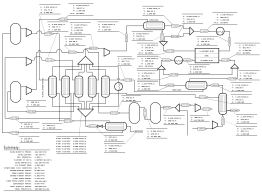

In [24]:
display(SVG(m.fs.write_pfd()))

In [ ]:
for flash in [m.fs.product_flash01, 
              #m.fs.product_flash02,
              m.fs.product_flash03,
              m.fs.product_flash04,
              m.fs.product_flash05]:
    print(flash.name)
    print(f"Diameter: {flash.diameter.value}m")
    print(f"Height: {flash.length.value}m")
    print()

In [ ]:
print(df)

In [ ]:
from idaes.core.util.model_diagnostics import DegeneracyHunter
def check_scaling(blk):
    jac, nlp = iscale.get_jacobian(blk, scaled=True)
    # djac = jac.todense()
    # print("Extreme Jacobian entries:")
    # for i in iscale.extreme_jacobian_entries(jac=jac, nlp=nlp, large=1E3, small=0):
    #     print(f"    {i[0]:.2e}, [{i[1]}, {i[2]}]")
    print("Badly scaled variables:")
    for i in iscale.extreme_jacobian_columns(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    print("\n\n" + "Badly scaled constraints:")
    for i in iscale.extreme_jacobian_rows(
            jac=jac, nlp=nlp, large=1E3, small=5E-3):
        print(f"    {i[0]:.2e}, [{i[1]}]")
    #print(f"Jacobian Condition Number: {iscale.jacobian_cond(jac=jac):.2e}")

    if not hasattr(blk, "obj"):
        blk.obj = pyo.Objective(expr=0)
    dh = DegeneracyHunter(blk, solver=pyo.SolverFactory('cbc'))
    dh.check_rank_equality_constraints(dense=True)
    variables = nlp.get_pyomo_variables()
    constraints = nlp.get_pyomo_equality_constraints()
    # ds = dh.find_candidate_equations()
    for i in np.where(abs(dh.v[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + variables[i].name)
    for i in np.where(abs(dh.u[:, -1]) > 0.1)[0]:
        print(str(i) + ": " + constraints[i].name)

    return (variables, constraints, jac, dh)

In [ ]:
variables, constraints, jac, dh = check_scaling(m.fs)

In [ ]:
m.fs.heat_source.report()

In [ ]:
dh.check_residuals(1e-6)

In [ ]:
dh.check_variable_bounds(relative=True)

In [ ]:
dir(m.fs)

In [ ]:
m.fs.product_flash05.report()

In [ ]:
m.fs.cmp04.report()

In [ ]:
m.fs.cmp04.ratioP_calculation[0.0].pprint()

In [ ]:
6.4790e+06/2.3923e+06